In [1]:
import emcee, copy
import numpy as np
from astropy.table import Table,Column
import matplotlib.pyplot as plt
import corner
from astropy.io import ascii
import pandas as pd

In [2]:
hgw = ascii.read('2020hgw_0.txt')
hgw_df = hgw.to_pandas()
hgw_df = hgw_df[['Time (MJD)', 'Log10(Bol. Lum)', 'Log10(Bol. Err)']]
hgw_df.to_csv('hgw_bol.txt', sep = ' ', header=False, index=False)

In [3]:
jfo = ascii.read('2020jfo_0.txt')
jfo_df = jfo.to_pandas()
jfo_df = jfo_df[['Time (MJD)', 'Log10(Bol. Lum)', 'Log10(Bol. Err)']]
jfo_df.to_csv('jfo_bol.txt', sep = ' ', header = False, index = False)

In [4]:
jww = ascii.read('2020jww_0.txt')
jww_df = jww.to_pandas()
jww_df = jww_df[['Time (MJD)', 'Log10(Bol. Lum)', 'Log10(Bol. Err)']]
jww_df.to_csv('jww_bol.txt', sep = ' ', header = False, index = False)

In [5]:
rth = ascii.read('2020rth_0.txt')
rth_df = rth.to_pandas()
rth_df = rth_df[['Time (MJD)', 'Log10(Bol. Lum)', 'Log10(Bol. Err)']]
rth_df.to_csv('rth_bol.txt', sep = ' ', header = False, index = False)

In [6]:
tly = ascii.read('2020tly_0.txt')
tly_df = tly.to_pandas()
tly_df = tly_df[['Time (MJD)', 'Log10(Bol. Lum)', 'Log10(Bol. Err)']]
tly_df.to_csv('tly_bol.txt', sep = ' ', header = False, index = False)

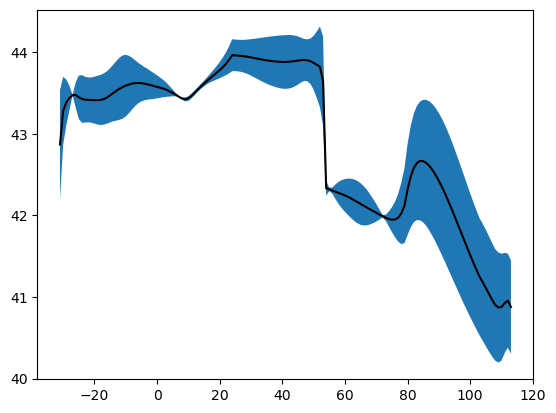

In [23]:
time = hgw_df['Time (MJD)']
val = hgw_df['Log10(Bol. Lum)']
err = abs(hgw_df['Log10(Bol. Lum)'] - hgw_df['Log10(Bol. Err)'])


plt.fill_between(time,val + err,val - err)
plt.plot(time,val,color = 'black')

<Axes: xlabel='Time (MJD)'>

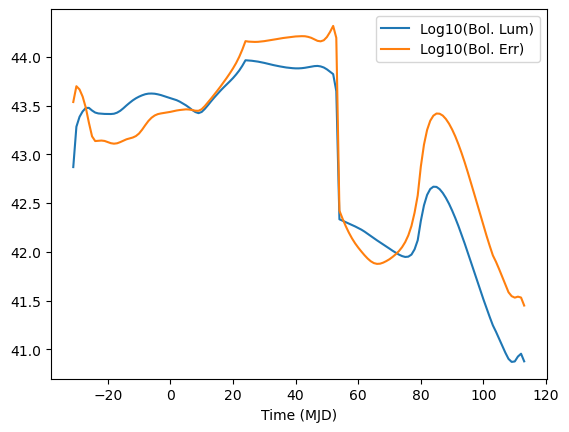

In [16]:
hgw_df.plot('Time (MJD)')

<ErrorbarContainer object of 3 artists>

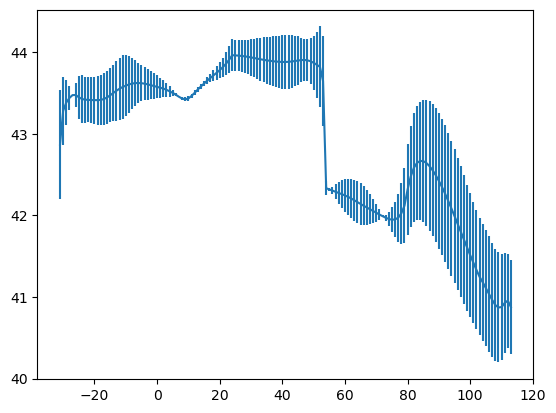

In [24]:
plt.errorbar(hgw_df['Time (MJD)'], hgw_df['Log10(Bol. Lum)'], yerr = abs(hgw_df['Log10(Bol. Lum)'] - hgw_df['Log10(Bol. Err)']))

<ErrorbarContainer object of 3 artists>

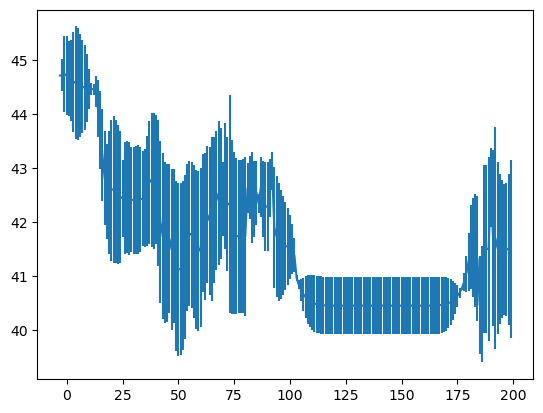

In [34]:
plt.errorbar(jfo_df['Time (MJD)'], jfo_df['Log10(Bol. Lum)'], yerr =np.abs(jfo_df['Log10(Bol. Lum)'] - jfo_df['Log10(Bol. Err)']))

<ErrorbarContainer object of 3 artists>

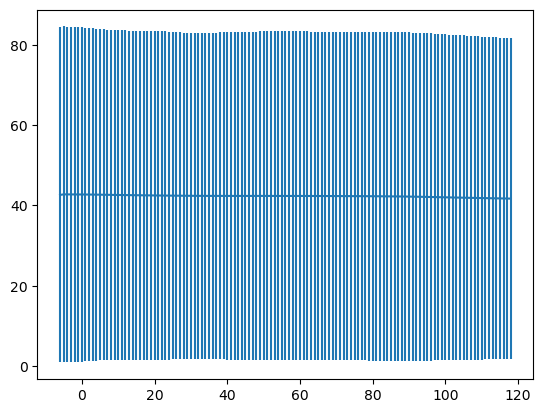

In [32]:
plt.errorbar(jww_df['Time (MJD)'], jww_df['Log10(Bol. Lum)'], yerr = jww_df['Log10(Bol. Err)'])

  0%|          | 20/5000 [00:00<00:52, 95.31it/s]C:\Users\JV\AppData\Local\Temp\ipykernel_15820\3559141191.py:9: RuntimeWarning: overflow encountered in exp
  return(-a/(1. + np.exp((time-tpt)/w))+p*time+m)
100%|██████████| 5000/5000 [00:48<00:00, 103.34it/s]

Best-fit parameters:
Param: 5.010536617633987 + 3.5161171566295355 - 3.4967560868740177
Param: 3.0559182593606637e+32 + 4.661953208241078e+53 - 3.0559182593606637e+32
Param: 3.6486088241108974e+30 + 1.1784895026529626e+52 - 3.6486088241108974e+30
Param: 0.016884539934158383 + 0.14732300952920818 - 0.15003276573525962
Param: -12.982736799508693 + 11.275060978048385 - 11.340152801375972
[5.010536617633987, 3.0559182593606637e+32, 3.6486088241108974e+30, 0.016884539934158383, -12.982736799508693]


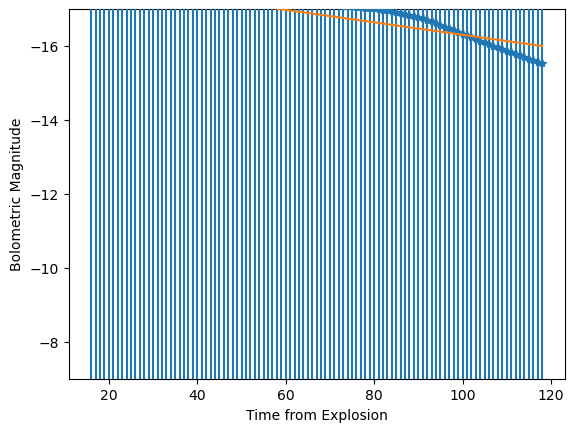

In [9]:
 
plt.clf()

# Input parameters - superbol file and MJD explosion/discovery date
data_file='jww_bol.txt'
mjd_start=0

def valenti_model(time, theta):
    a, tpt, w, p, m = theta
    return(-a/(1. + np.exp((time-tpt)/w))+p*time+m)

def lnlikelihood(theta, lum, dlum, time):
    model_lum = valenti_model(time, theta)
    
    # Set parameter range value
    a, tpt, w, p, m = theta
    if a<0.01: return(-np.inf)
    if a>10.0: return(-np.inf)
    if tpt<10.0: return(-np.inf)
    if w<0.01: return(-np.inf)
    
    inv_sigma = 1./dlum**2
    return(-0.5 * np.sum((lum-model_lum)**2 * inv_sigma))

def load_table(data_file, mjd_start=mjd_start, mask_date=15):
    # The code will automatically mask data mask_date days from the input reference date.
    # Change this value in order to adjust the amount of data that's included/excluded
    
    table = Table.read(data_file, format='ascii',names=('MJD','lum','dlum'))
    #print(table)
    # Want to fit versus a magnitude rather than actual luminosity, so convert lum to Mbol
    # Here 83.9605452803 = 2.5*log10(3.839e33) for Solar luminosity
    # 4.74 is bolometric luminosity of the Sun
    table['MJD'] = table['MJD']
    Mbol = -2.5*table['lum'] + 83.9605452803 + 4.74
    Mbolerr = table['dlum'] 

    
    table.add_column(Column(Mbol, name='Mbol'))
    table.add_column(Column(Mbolerr, name='Mbolerr'))
    
    newcol=Column(table['MJD'].data-mjd_start,name='t_exp')
    table.add_column(newcol)
    
    mask = table['t_exp']>mask_date
    table=table[mask]
   # print(table)
    return(table)

def mcmc_valenti(data_file, ndim=5, nwalkers=100, inflate_errors=0.1):
    
    # I'm adding a parameter to inflate the error bars because the code appears to underfit the
    # late time decline due to nickel, which is primarily what we're interested in
    
    params = [1.7391707763335567, 111.06179709805089, 7.203197652533321, 0.008194307783125725, -13.583601384015793]
    pos = [params + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]
    
    table = load_table(data_file)
    mask = np.abs(table['MJD'] - 58923) < 1
    table = table[~mask]
    table['Mbolerr'] = np.sqrt(table['Mbolerr']**2+inflate_errors**2)
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlikelihood, 
                                    args=(table['Mbol'],
                                          table['Mbolerr'],
                                          table['t_exp']))
    
    sampler.run_mcmc(pos, 5000, progress=True)
    samples = sampler.chain[:, 99:, :].reshape((-1, ndim))
    
    return(samples)

def get_param_uncertainties(samples):
    
    vals = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                                 zip(*np.percentile(samples, [16, 50, 84],
                                                    axis=0)))
    
    vals = [v for v in vals]
    
    return(vals)
    
samples=mcmc_valenti(data_file)
params=get_param_uncertainties(samples)
   

print('Best-fit parameters:')
for p in copy.copy(params):
    print('Param: {0} + {1} - {2}'.format(p[0], p[1], p[2]))

best_fit=[p[0] for p in copy.copy(params)]
print(best_fit)
table = load_table(data_file)
plt.errorbar(table['MJD']-mjd_start, table['Mbol'], yerr=table['Mbolerr'], marker='*', zorder=5)
# print(table['MJD'] - mjd_start)
# print(table['Mbol'])
    
model_lum=valenti_model(table['MJD']-mjd_start, best_fit)

plt.plot(table['MJD']-mjd_start, model_lum, zorder=10)

plt.ylim([-7,-17])
plt.ylabel('Bolometric Magnitude')
plt.xlabel('Time from Explosion')

plt.show()